In [2]:
from pathlib import Path
import pandas as pd
import json
import pyarrow as pa
import matplotlib

In [3]:
pd.set_option('display.max_colwidth', None)
pd.options.display.max_columns = None

In [4]:
#MOA
data_dir_moa = Path('C:/Users/Sanjana/Desktop/AdverseDrugReactions_SignalPrediction/Data/parquet/mechanismOfAction/')
moa_full_df = pd.concat(
    pd.read_parquet(parquet_file)
    for parquet_file in data_dir_moa.glob('*.parquet')
)

#AE
data_dir = Path('C:/Users/Sanjana/Desktop/AdverseDrugReactions_SignalPrediction/Data/parquet/fda/significantAdverseDrugReactions/')
ae_full_df = pd.concat(
    pd.read_parquet(parquet_file)
    for parquet_file in data_dir.glob('*.parquet')
)

#TARGETS-PATHWAY
data_dir_targets = Path('C:/Users/Sanjana/Desktop/AdverseDrugReactions_SignalPrediction/Data/parquet/targets/')
targets_full_df = pd.concat(
    pd.read_parquet(parquet_file)
    for parquet_file in data_dir_targets.glob('*.parquet')
)

In [5]:
#Drugs
data_dir_drug = Path('C:/Users/Sanjana/Desktop/AdverseDrugReactions_SignalPrediction/Data/parquet/molecule/')
drugs_full_df = pd.concat(
    pd.read_parquet(parquet_file)
    for parquet_file in data_dir_drug.glob('*.parquet')
)

In [6]:
#Indications
data_dir_indications = Path('C:/Users/Sanjana/Desktop/AdverseDrugReactions_SignalPrediction/Data/parquet/indication/')
indications_full_df = pd.concat(
    pd.read_parquet(parquet_file)
    for parquet_file in data_dir_indications.glob('*.parquet')
)

In [7]:
#Known Drugs
data_dir_known_drugs = Path('C:/Users/Sanjana/Desktop/AdverseDrugReactions_SignalPrediction/Data/parquet/knownDrugsAggregated/')
known_drugs_full_df = pd.concat(
    pd.read_parquet(parquet_file)
    for parquet_file in data_dir_known_drugs.glob('*.parquet')
)

In [8]:
#Baseline Expression
data_dir_be = Path('C:/Users/Sanjana/Desktop/AdverseDrugReactions_SignalPrediction/Data/parquet/baselineExpression/')
be_full_df = pd.concat(pd.read_parquet(parquet_file)
    for parquet_file in data_dir_be.glob('*.parquet')
)

In [25]:
#BaLACK bOX WARNINGS
data_dir_warnings = Path('C:/Users/Sanjana/Desktop/AdverseDrugReactions_SignalPrediction/Data/parquet/drugWarnings/')
warnings_full_df = pd.concat(pd.read_parquet(parquet_file)
    for parquet_file in data_dir_warnings.glob('*.parquet')
)



### Mechanism of Action

In [9]:
select_moa_full_df = moa_full_df[['chemblIds','actionType','mechanismOfAction','targetName','targetType','targets']]
exploded_moa = select_moa_full_df.explode('chemblIds')
exploded_moa = exploded_moa.explode('targets')
exploded_moa = exploded_moa.apply(lambda x : x.str.strip())

In [77]:
#clean_moa = select_moa_full_df[select_moa_full_df['targets'].str.len()!= 0]

### Flatten pathway from Target dataframe

In [10]:
target_pathway = targets_full_df[targets_full_df.pathways.notnull()]

target_pathway = target_pathway[['id','approvedName', 'pathways']]

target_pathway = target_pathway[['id','approvedName', 'pathways']]

target_pathway = target_pathway[target_pathway.id.notnull()]

exploded_target_pathway = target_pathway.explode('pathways')

exploded_target_pathway['pathways'] =  exploded_target_pathway['pathways'].astype("string")

exploded_target_pathway['pathways'] = exploded_target_pathway.pathways.str.strip('{}')

exploded_target_pathway['pathways'] = exploded_target_pathway.pathways.str.replace("'",'')

pathways= exploded_target_pathway['pathways']

### Split pathway column into three columns - 'pathwayId', 'pathway','topLevelTerm'

In [11]:
pathways =  exploded_target_pathway.pathways.astype(str).str.split(",",expand=True)

pathways.columns = ["pathwayId", "pathway","topLevelTerm","empty1","empty2","empty3"]

pathways.drop(pathways.columns[[3,4,5]],axis=1,inplace=True)

### Lamda function to strip unwanted characters

In [12]:
pathways = pathways.apply(lambda x : x.str.split('\:').str[-1].str.strip())

### Merge back pathway columns - 'pathwayId', 'pathway' and 'topLevelTerm' to 'exploded_target_pathways' dataframe

In [13]:
wide_taget_pathway = pd.concat([exploded_target_pathway,pathways],axis=1)

wide_taget_pathway = wide_taget_pathway.drop('pathways',axis=1)

wide_taget_pathway = wide_taget_pathway.apply(lambda x : x.str.strip())

### Merge drug, target, pathway and mechanism of action information from  'exploded_moa' with 'wide_target_pathway'

In [14]:
drug_targets_moa_pathway = pd.merge(exploded_moa,wide_taget_pathway, left_on='targets',right_on = 'id',how='left')

drug_targets_moa_pathway = drug_targets_moa_pathway.drop('id', axis = 1)

clean_drug_targets_moa_pathway = drug_targets_moa_pathway[drug_targets_moa_pathway.pathway.notnull()]

clean_drug_targets_moa_pathway = clean_drug_targets_moa_pathway[clean_drug_targets_moa_pathway.targets.notnull()]

#### INDICATIONS

In [33]:
indications_full_df = indications_full_df[indications_full_df.id.notnull()]

exploded_indications = indications_full_df.explode('approvedIndications')

exploded_indications.drop(['indications','indicationCount'], axis =1,inplace=True)

exploded_indications = exploded_indications[exploded_indications.approvedIndications.notna()]

exploded_indications = exploded_indications.drop_duplicates(subset = ['id','approvedIndications'])

### New unified dataset with Indications , Action type, Target; removed Mechanism of action

In [66]:
drug_targets_moa_pathway_indications = pd.merge(clean_drug_targets_moa_pathway,exploded_indications, left_on='chemblIds',right_on = 'id',how='inner')

In [73]:
drug_targets_moa_pathway_indications

,chemblIds,actionType,targets,approvedName,topLevelTerm,approvedIndications
0,CHEMBL3545367,ANTAGONIST,ENSG00000137252,hypocretin receptor 2,Signal Transduction,EFO_0004698
2,CHEMBL3545367,ANTAGONIST,ENSG00000121764,hypocretin receptor 1,Signal Transduction,EFO_0004698
4,CHEMBL2028987,ANTAGONIST,ENSG00000109163,gonadotropin releasing hormone receptor,Signal Transduction,EFO_0000673
5,CHEMBL2028987,ANTAGONIST,ENSG00000109163,gonadotropin releasing hormone receptor,Signal Transduction,MONDO_0008315
6,CHEMBL2028987,ANTAGONIST,ENSG00000109163,gonadotropin releasing hormone receptor,Signal Transduction,EFO_0001663
...,...,...,...,...,...,...
141964,CHEMBL461522,INHIBITOR,ENSG00000073756,prostaglandin-endoperoxide synthase 2,Metabolism,EFO_0003843
141967,CHEMBL461522,INHIBITOR,ENSG00000073756,prostaglandin-endoperoxide synthase 2,Immune System,HP_0001945
141968,CHEMBL461522,INHIBITOR,ENSG00000073756,prostaglandin-endoperoxide synthase 2,Immune System,EFO_0003843
141981,CHEMBL461522,INHIBITOR,ENSG00000095303,prostaglandin-endoperoxide synthase 1,Metabolism,HP_0001945


In [68]:
drug_targets_moa_pathway_indications.drop(['id','targetName','targetType', 'pathwayId','pathway','mechanismOfAction','group'],axis=1,inplace=True)

drug_targets_moa_pathway_indications = drug_targets_moa_pathway_indications.drop_duplicates(subset=['chemblIds','actionType','targets','approvedName','topLevelTerm','approvedIndications'])

### Add 'ACTION_TYPE' to ADVERSE EVENTS dataset

#### Remove duplicates

In [40]:
moa_with_drug_action_type = exploded_moa [['chemblIds','actionType']]

moa_with_drug_action_type = moa_with_drug_action_type.drop_duplicates(subset=['chemblIds'])

ae_action_type =  pd.merge(ae_full_df,moa_with_drug_action_type, left_on = 'chembl_id', right_on = 'chemblIds', how = 'left')

clean_ae_action_type = ae_action_type[ae_action_type.actionType.notna()]

summary_ae_drug_action_type = clean_ae_action_type[['actionType','count','event']].groupby(['actionType']).agg(adverse_event_count= ('event','count'),sum_reported_adverse_events=('count','sum'))

#summary_ae_drug_action_type

In [24]:
summary_drug_mechanismOfAction = clean_drug_targets_moa_pathway.groupby('mechanismOfAction').agg(Frequency_distribution_Mechanism_of_action= ('chemblIds','count'))

summary_drug_targets = clean_drug_targets_moa_pathway.groupby('targets').agg(Frequency_distribution_targets= ('chemblIds','count'))

summary_drug_pathways = clean_drug_targets_moa_pathway.groupby('pathway').agg(Frequency_distribution_pathway= ('chemblIds','count'))

summary_cae_moa = ae_moa.groupby('topLevelTerm').agg(adverse_event_count= ('event','count'))

## Exploratory Data Analysis (EDA) 

In [29]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt


array([[<Axes: title={'center': 'Frequency_distribution_Mechanism_of_action'}>]],
      dtype=object)

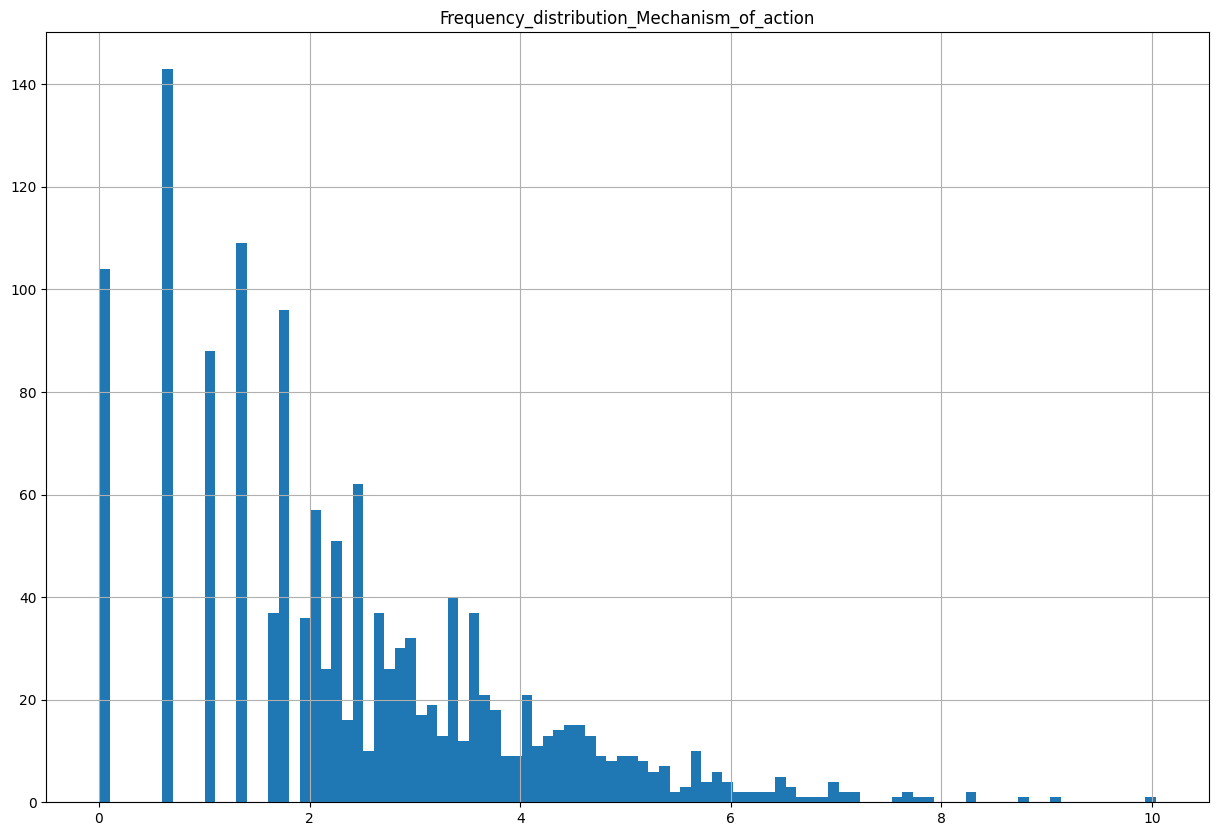

In [32]:

np.log(summary_drug_mechanismOfAction).hist(bins=100,figsize=(15, 10))

In [39]:
#summary_drug_pathways.hist(bins=np.histogram_bin_edges(summary_drug_pathways),figsize=(15, 10))

In [38]:
#summary_drug_targets.hist(bins=np.histogram_bin_edges(summary_drug_targets),figsize=(15, 10))

In [37]:
#for column in summary_clean_drug_targets_moa_pathway.columns:
 #   plt.figure()             # <==================== here!
  #  sns.distplot(summary_clean_drug_targets_moa_pathway[column])

### Unique category count of each column

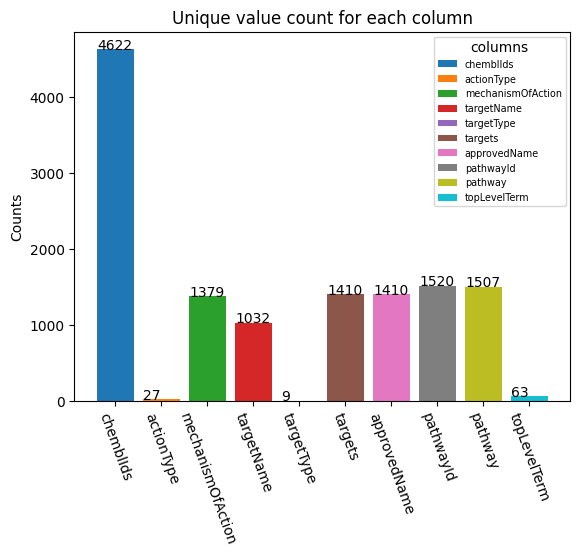

In [14]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

columns = clean_drug_targets_moa_pathway.columns.tolist()
counts = clean_drug_targets_moa_pathway.nunique().tolist()
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf','#0000EE','#FFEBCD','#E3CF57']
#bar_labels = ['red', 'blue', '_red', 'orange']
#bar_colors = ['tab:red', 'tab:blue', 'tab:red', 'tab:orange']

ax.bar(columns, counts, label=columns, color=colors)
xlocs, xlabs = plt.xticks()

ax.set_ylabel('Counts')
ax.set_title('Unique value count for each column')
ax.legend(title='columns',fontsize ='x-small')
ax.tick_params('x', labelrotation=290)

for i, v in enumerate(counts):
    plt.text(xlocs[i] - 0.40, v + 0.01, str(v))

plt.show()

### Missing value count in each column

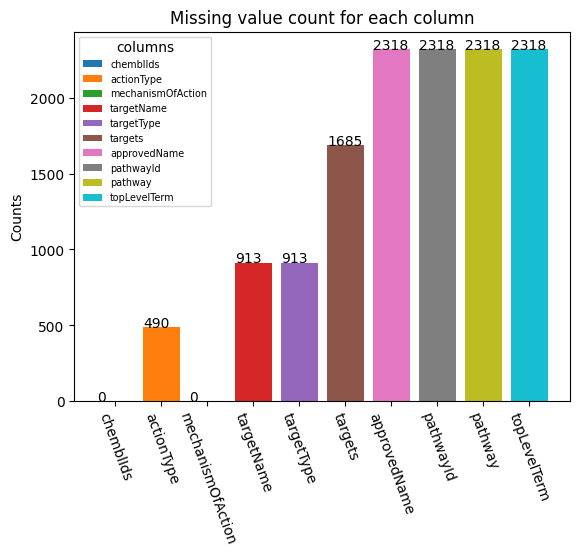

In [17]:

fig_missing, ax_missing = plt.subplots()

columns = drug_targets_moa_pathway.columns.tolist()
missing_count = drug_targets_moa_pathway.isna().sum().tolist()
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf','#0000EE','#FFEBCD','#E3CF57']
#bar_labels = ['red', 'blue', '_red', 'orange']
#bar_colors = ['tab:red', 'tab:blue', 'tab:red', 'tab:orange']

ax_missing.bar(columns, missing_count, label=columns, color=colors)
xlocs, xlabs = plt.xticks()
ax_missing.set_ylabel('Counts')
ax_missing.set_title('Missing value count for each column')
ax_missing.legend(title='columns',fontsize ='x-small')
ax_missing.tick_params('x', labelrotation=290)

for i, v in enumerate(missing_count):
    plt.text(xlocs[i] - 0.40, v + 0.01, str(v))

plt.show()

### Aderse event counts based on Drug Type

In [18]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Number of Adverfese Events for each drug type')

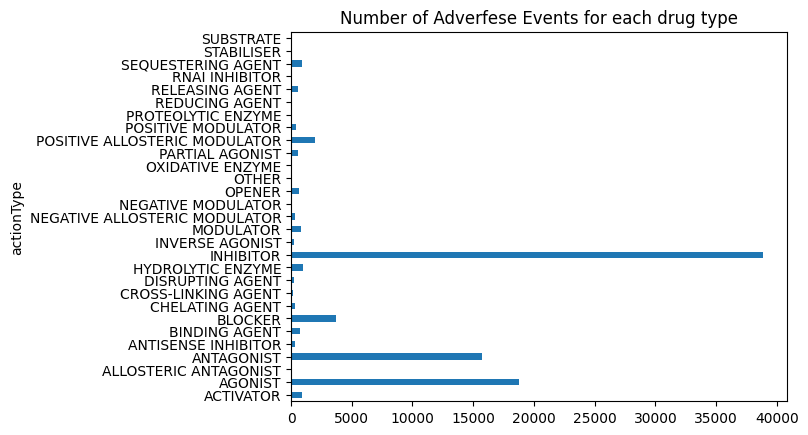

In [19]:
fig_ae_drug, ax_ae_drug = plt.subplots()
summary_ae_drug_action_type['adverse_event_count'].plot.barh()
ax_ae_drug.set_title('Number of Adverfese Events for each drug type')



Text(0.5, 1.0, 'Reported case counts for each drug type')

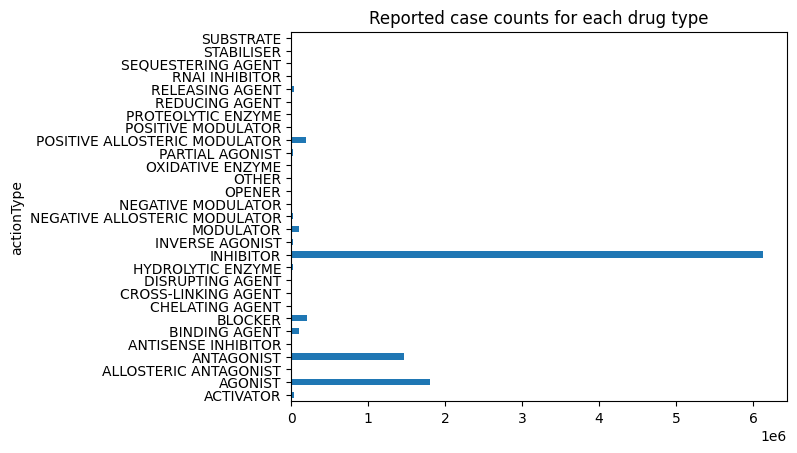

In [22]:
fig_ae_drug1, ax_ae_drug1 = plt.subplots()
summary_ae_drug_action_type['sum_reported_adverse_events'].plot.barh()
ax_ae_drug1.set_title('Reported case counts for each drug type')

Text(0.5, 1.0, 'Adverse Events count for each pathway type')

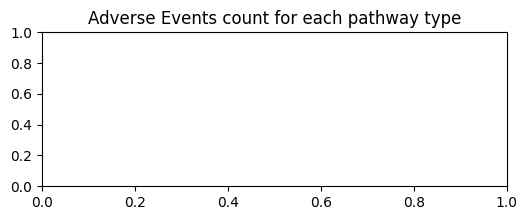

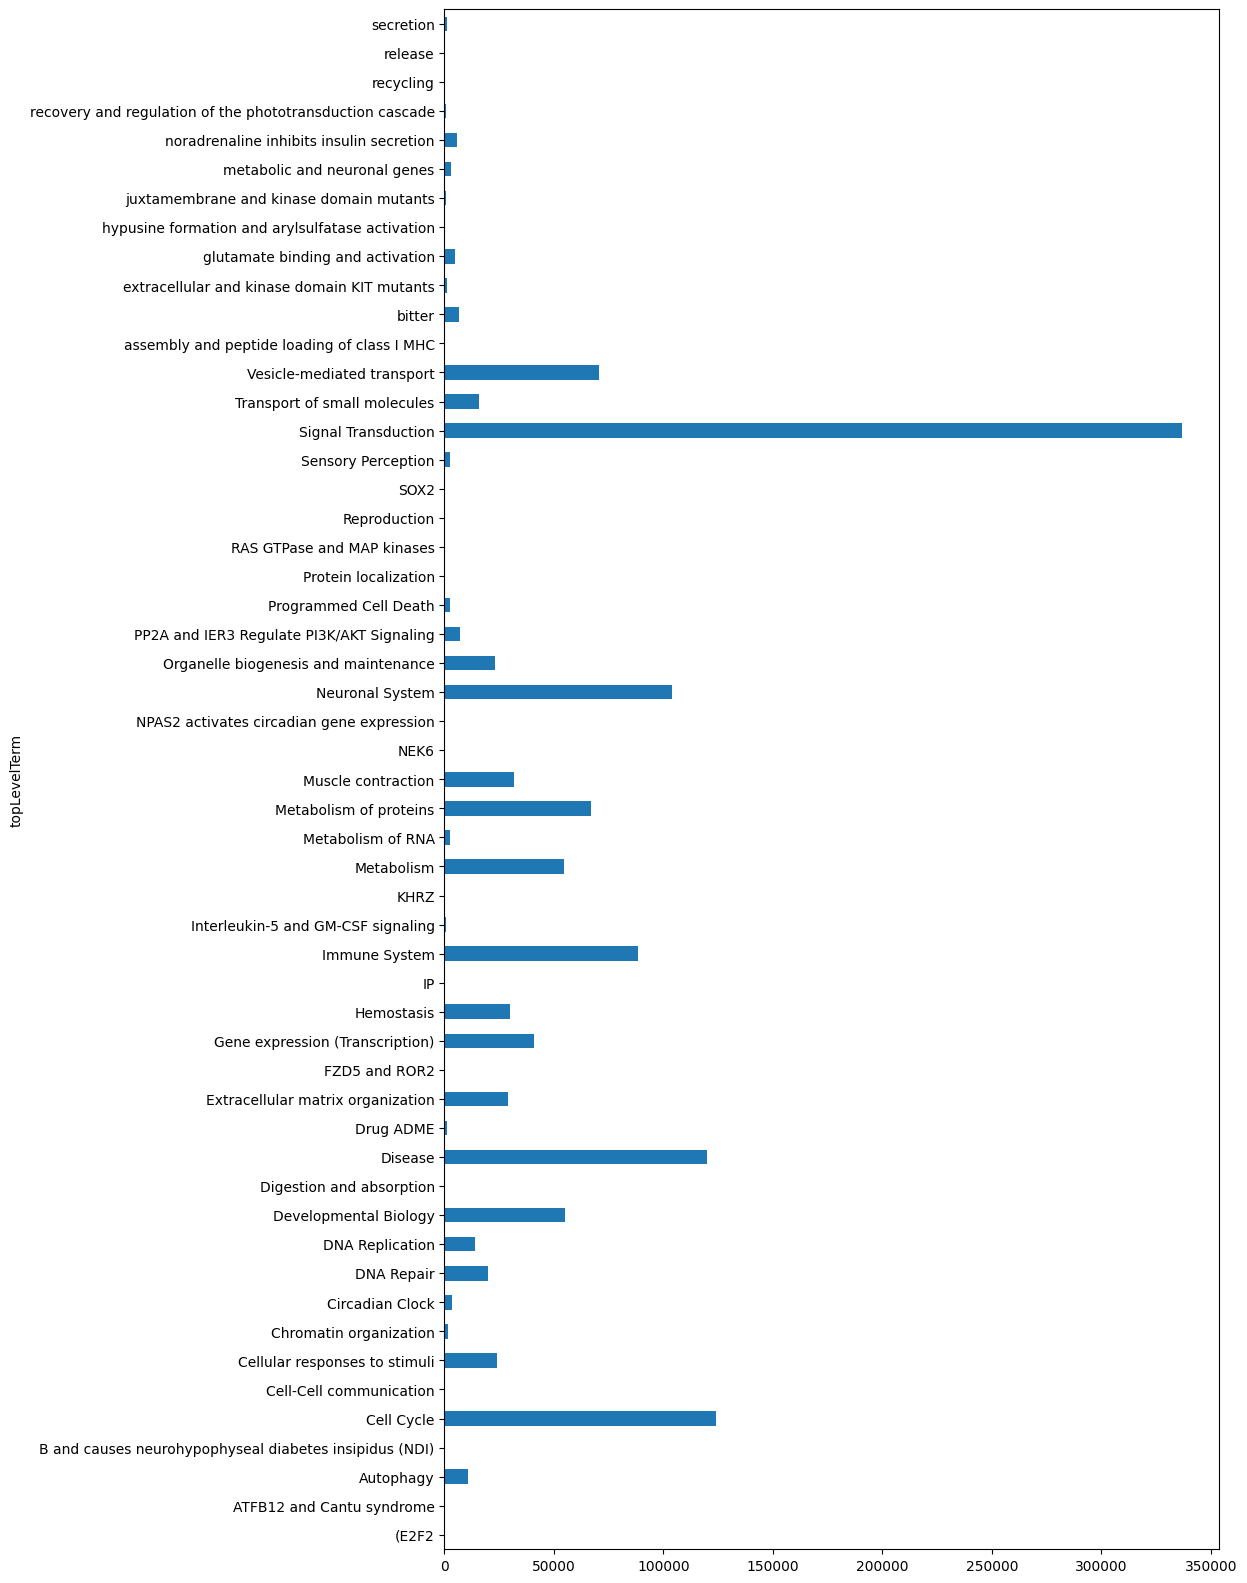

In [479]:

fig_top_lvl_drug1, ax_top_lvl_drug1 = plt.subplots()
plt.figure(figsize=(10,20))
summary_cae_moa['adverse_event_count'].plot.barh()
ax_top_lvl_drug1.set_title('Adverse Events count for each pathway type')


## Correaltion - CramersV

In [488]:
import scipy
from sklearn import preprocessing
label = preprocessing.LabelEncoder()
from scipy.stats import chi2_contingency
import numpy as np

In [620]:
ae_moa = pd.merge(ae_full_df,clean_drug_targets_moa_pathway, left_on = 'chembl_id', right_on = 'chemblIds', how = 'inner')

ae_moa = ae_moa[['chembl_id','event','actionType','mechanismOfAction','targets','pathway','topLevelTerm']]

In [603]:
CrosstabResult = pd.crosstab(index=ae_moa['event'], columns=ae_moa['actionType'])
actionType = scipy.stats.contingency.association(CrosstabResult)

In [621]:
data_encoded = pd.DataFrame() 
for i in ae_moa.columns:
    data_encoded[i]=label.fit_transform(ae_moa[i])


def cramers_V(var1,var2) :
    crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) # Cross table building
    stat = chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
    obs = np.sum(crosstab) # Number of observations
    mini = min(crosstab.shape)-1 # Take the minimum value between the columns and the rows of the cross table
    return (stat/(obs*mini))

rows=[]  
for var1 in data_encoded.columns.tolist(): 
    col=[]
    for var2 in data_encoded.columns.tolist(): 
        cramers =cramers_V(data_encoded[var1], data_encoded[var2])
        col.append(round(cramers,2))
    rows.append(col)
cramers_results = np.array(rows) 
df = pd.DataFrame(cramers_results,columns = data_encoded.columns, index=data_encoded.columns)

In [628]:
def cramers_rule(var1,var2) :
    crosstab=pd.crosstab(index=var1, columns=var2)
    stat = scipy.stats.contingency.association(crosstab)
    return stat

rows=[]  
for var1 in ae_moa.columns.tolist(): 
    col=[]
    for var2 in ae_moa.columns.tolist(): 
        cramers =cramers_rule(ae_moa[var1], ae_moa[var2])
        col.append(round(cramers,2))
    rows.append(col)
cramers_results = np.array(rows) 
craemrs_correlation = pd.DataFrame(cramers_results,columns = data_encoded.columns, index=data_encoded.columns)

In [630]:
craemrs_correlation

,chembl_id,event,actionType,mechanismOfAction,targets,pathway,topLevelTerm
chembl_id,1.00,0.35,0.94,0.86,0.61,0.33,0.40
event,0.35,1.00,0.48,0.34,0.25,0.13,0.21
actionType,0.94,0.48,1.00,1.00,0.75,0.60,0.29
mechanismOfAction,0.86,0.34,1.00,1.00,0.82,0.49,0.45
targets,0.61,0.25,0.75,0.82,1.00,0.46,0.51
pathway,0.33,0.13,0.60,0.49,0.46,1.00,1.00
topLevelTerm,0.40,0.21,0.29,0.45,0.51,1.00,1.00


In [639]:
craemrs_correlation.style.background_gradient(cmap='YlGnBu')

,chembl_id,event,actionType,mechanismOfAction,targets,pathway,topLevelTerm
chembl_id,1.000000,0.350000,0.940000,0.860000,0.610000,0.330000,0.400000
event,0.350000,1.000000,0.480000,0.340000,0.250000,0.130000,0.210000
actionType,0.940000,0.480000,1.000000,1.000000,0.750000,0.600000,0.290000
mechanismOfAction,0.860000,0.340000,1.000000,1.000000,0.820000,0.490000,0.450000
targets,0.610000,0.250000,0.750000,0.820000,1.000000,0.460000,0.510000
pathway,0.330000,0.130000,0.600000,0.490000,0.460000,1.000000,1.000000
topLevelTerm,0.400000,0.210000,0.290000,0.450000,0.510000,1.000000,1.000000


# Similarity

In [41]:
import sklearn
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import jaccard_score
from scipy.spatial.distance import squareform
from scipy.spatial.distance import pdist
import numpy as np

### Similarity with "mechanismOfAction","targets","pathway"

In [15]:
drug_count_per_actionType = clean_drug_targets_moa_pathway[['chemblIds','actionType']].groupby(['actionType']).agg(count_drug = ('chemblIds','count'))

### Encode categorical columns

In [42]:
one_hot_encoded = pd.get_dummies(clean_drug_targets_moa_pathway[clean_drug_targets_moa_pathway['actionType']=='AGONIST'], columns= ["mechanismOfAction","targets","pathway"])

In [43]:
one_hot_encoded.drop(['actionType','targetName','targetType','approvedName','pathwayId'],axis=1,inplace=True)

In [44]:
one_hot_encoded.set_index('chemblIds',inplace=True)

### Convert to numpy array

In [45]:
nd_array = one_hot_encoded.to_numpy()

### Calculate Similarity -Jaccard

In [46]:

jac_sim = 1 - pairwise_distances(nd_array, metric='jaccard')



c:\Users\ArulSeetharaman\Miniconda3\lib\site-packages\sklearn\metrics\pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


In [47]:
jac_sim_df = pd.DataFrame(jac_sim, index= one_hot_encoded.index, columns=one_hot_encoded.index,)

In [48]:
jac_sim_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6957 entries, CHEMBL1201664 to CHEMBL1201509
Columns: 6957 entries, CHEMBL1201664 to CHEMBL1201509
dtypes: float64(6957)
memory usage: 369.6+ MB


### Transform to Longform

In [49]:
# move to long form
long_form = jac_sim_df.unstack()

# rename columns and turn into a dataframe
long_form.index.rename(['Drug_1', 'Drug_2'], inplace=True)
long_form = long_form.to_frame('jaccard_similarity').reset_index()

### Filter results to 90%  drug similarity

In [50]:
similar_agonist = long_form[
    (long_form['jaccard_similarity'] >= 0.90) 
    & 
    (long_form['Drug_1'] != long_form['Drug_2'])
].sort_values('jaccard_similarity',ascending = True)

### Drop multiple comparisons (duplicate drug pairs)

In [51]:
similar_agonist = similar_agonist.drop_duplicates(subset=['Drug_1','Drug_2'])

In [52]:
similar_agonist

,Drug_1,Drug_2,jaccard_similarity
397,CHEMBL1201664,CHEMBL1201631,1.0
31146651,CHEMBL1683,CHEMBL1650,1.0
31146566,CHEMBL1683,CHEMBL1200845,1.0
31146442,CHEMBL1683,CHEMBL977,1.0
31146433,CHEMBL1683,CHEMBL1200495,1.0
...,...,...,...
14418259,CHEMBL282686,CHEMBL1267,1.0
14417725,CHEMBL282686,CHEMBL3545295,1.0
14417408,CHEMBL282686,CHEMBL121,1.0
14419639,CHEMBL282686,CHEMBL3545279,1.0


### Group drugs by adverse events

In [53]:
adverse_events_grouped = ae_full_df.groupby('chembl_id')['event'].apply(list).reset_index(name='adverse_events')

### Merge similar drugs with Adverse Events

In [54]:
similar_agonist_ae = pd.merge(similar_agonist,adverse_events_grouped.loc[736:], left_on= 'Drug_1'  , right_on = 'chembl_id'  , how ='left')

similar_agonist_ae = pd.merge(similar_agonist_ae,adverse_events_grouped.loc[736:], left_on= 'Drug_2'  , right_on = 'chembl_id'  , how ='left')



In [55]:
similar_agonist_ae = similar_agonist_ae[(similar_agonist_ae.chembl_id_x.notna()) | (similar_agonist_ae.chembl_id_y.notna())]

In [56]:
isna = similar_agonist_ae['adverse_events_x'].isna()
similar_agonist_ae.loc[isna,'adverse_events_x'] = pd.Series([[]] * isna.sum()).values

isnay = similar_agonist_ae['adverse_events_y'].isna()
similar_agonist_ae.loc[isnay,'adverse_events_y'] = pd.Series([[]] * isna.sum()).values

### Find common AEs

In [57]:
similar_agonist_ae['common_adverse_events'] = [list(set(a).intersection(set(b))) for a, b in zip(similar_agonist_ae.adverse_events_x, similar_agonist_ae.adverse_events_y)]

### Replace blank AEs with left out pair AE's value

In [58]:
similar_agonist_ae.loc[similar_agonist_ae.adverse_events_x.str.len() == 0 , 'common_adverse_events'] = similar_agonist_ae['adverse_events_y']
similar_agonist_ae.loc[similar_agonist_ae.adverse_events_y.str.len() == 0 , 'common_adverse_events'] = similar_agonist_ae['adverse_events_x']

### Remove records with no common AEs

In [59]:
similar_agonist_ae = similar_agonist_ae[similar_agonist_ae.common_adverse_events.str.len() > 0]

In [60]:
similar_agonist_ae['common_adverse_events'] = similar_agonist_ae.common_adverse_events.astype("string").str.replace('[', '').str.replace(']', '').str.replace('"', '')

In [61]:
similar_agonist_ae_grouped = similar_agonist_ae.groupby('Drug_1')[['Drug_2','common_adverse_events']].agg(lambda x: list(x)).reset_index()

In [62]:
similar_agonist_ae_grouped['common_adverse_events'] = similar_agonist_ae_grouped.common_adverse_events.astype("string").str.replace('[', '').str.replace(']', '').str.replace('"', '')

### Remove Duplicate AEs

In [63]:
similar_agonist_ae_grouped['unique_ae'] = similar_agonist_ae_grouped['common_adverse_events'].apply(lambda x: set(x.split(',')))

In [64]:
similar_agonist_ae_grouped = similar_agonist_ae_grouped.drop('common_adverse_events',axis=1)

### Find AEs for given MOA, TARGET and PATHWAY

## Testing

### In-sample Test split: 20% of drugs reported in AEs dataset

In [363]:
test_drugs = adverse_events_grouped['chembl_id'].head(735)

In [272]:
in_sample_test_set = clean_drug_targets_moa_pathway[clean_drug_targets_moa_pathway.chemblIds.isin(test_drugs)]

### Filter to AGONIST drug action type

In [273]:
in_sample_test_set = in_sample_test_set[in_sample_test_set['actionType'] == "AGONIST"]

### Similar test drugs

In [274]:
actionType      = "AGONIST"
moa             = "Beta-2 adrenergic receptor agonist"
target          = "ENSG00000169252"
pathway         = "Ub-specific processing proteases"

In [275]:
test_similar_drugs = clean_drug_targets_moa_pathway[ (clean_drug_targets_moa_pathway['actionType']           == actionType ) & 
                                (clean_drug_targets_moa_pathway['mechanismOfAction']                   == moa)         &
                                (clean_drug_targets_moa_pathway['targets']                             == target)      &
                                (clean_drug_targets_moa_pathway['pathway']                             == pathway)]['chemblIds']

In [296]:
predicted_true_comparison = pd.merge(similar_agonist_ae_grouped[similar_agonist_ae_grouped.Drug_1.isin(test_drugs)],adverse_events_grouped, left_on= 'Drug_1', right_on= 'chembl_id', how= 'inner')

In [297]:
predicted_true_comparison['unique_ae_array'] = [','.join(map(str, l)) for l in predicted_true_comparison['unique_ae']]

In [298]:
predicted_true_comparison['unique_ae_array'] = predicted_true_comparison.unique_ae_array.str.replace("'","").str.split(",")

In [299]:
predicted_true_comparison['unique_ae_array'] = predicted_true_comparison['unique_ae_array'].apply(lambda x: list(map(str.strip, x)))

In [300]:
predicted_true_comparison['unique_ae_array'] = predicted_true_comparison.unique_ae_array.astype("string")

In [301]:
predicted_true_comparison['adverse_events'] = predicted_true_comparison.adverse_events.astype("string")

In [302]:
predicted_true_comparison['common_predicted_actual'] = [list(set(a).intersection(set(b))) for a, b in zip(predicted_true_comparison.adverse_events.str.split(","), predicted_true_comparison.unique_ae_array.str.split(","))]

In [331]:
predicted_true_comparison['actual_count'] = predicted_true_comparison.adverse_events.str.split(",").str.len()
predicted_true_comparison['predicted_count'] = predicted_true_comparison.common_predicted_actual.astype("string").str.split(",").str.len()

In [334]:
predicted_true_comparison = predicted_true_comparison.drop('unique_ae', axis=1)

In [336]:
predicted_true_comparison['accuracy'] = round((predicted_true_comparison['predicted_count'] /predicted_true_comparison['actual_count']),2) 

In [353]:
#predicted_true_comparison.accuracy.mean()

## Test Data

In [354]:
in_sample_test_set

,chemblIds,actionType,mechanismOfAction,targetName,targetType,targets,approvedName,pathwayId,pathway,topLevelTerm
179,CHEMBL1082607,AGONIST,Beta-2 adrenergic receptor agonist,Beta-2 adrenergic receptor,single protein,ENSG00000169252,adrenoceptor beta 2,R-HSA-5689880,Ub-specific processing proteases,Metabolism of proteins
180,CHEMBL1082607,AGONIST,Beta-2 adrenergic receptor agonist,Beta-2 adrenergic receptor,single protein,ENSG00000169252,adrenoceptor beta 2,R-HSA-418555,G alpha (s) signalling events,Signal Transduction
181,CHEMBL1082607,AGONIST,Beta-2 adrenergic receptor agonist,Beta-2 adrenergic receptor,single protein,ENSG00000169252,adrenoceptor beta 2,R-HSA-390696,Adrenoceptors,Signal Transduction
182,CHEMBL1082607,AGONIST,Beta-2 adrenergic receptor agonist,Beta-2 adrenergic receptor,single protein,ENSG00000169252,adrenoceptor beta 2,R-HSA-8856825,Cargo recognition for clathrin-mediated endocytosis,Vesicle-mediated transport
183,CHEMBL1082607,AGONIST,Beta-2 adrenergic receptor agonist,Beta-2 adrenergic receptor,single protein,ENSG00000169252,adrenoceptor beta 2,R-HSA-8856828,Clathrin-mediated endocytosis,Vesicle-mediated transport
...,...,...,...,...,...,...,...,...,...,...
118468,CHEMBL1200495,AGONIST,Glucocorticoid receptor agonist,Glucocorticoid receptor,single protein,ENSG00000113580,nuclear receptor subfamily 3 group C member 1,R-HSA-400253,Circadian Clock,Circadian Clock
118469,CHEMBL1200495,AGONIST,Glucocorticoid receptor agonist,Glucocorticoid receptor,single protein,ENSG00000113580,nuclear receptor subfamily 3 group C member 1,R-HSA-9768777,Regulation of NPAS4 gene transcription,Gene expression (Transcription)
118470,CHEMBL1200495,AGONIST,Glucocorticoid receptor agonist,Glucocorticoid receptor,single protein,ENSG00000113580,nuclear receptor subfamily 3 group C member 1,R-HSA-383280,Nuclear Receptor transcription pathway,Gene expression (Transcription)
119031,CHEMBL1201509,AGONIST,Luteinizing hormone/Choriogonadotropin receptor agonist,Luteinizing hormone/Choriogonadotropin receptor,single protein,ENSG00000138039,luteinizing hormone/choriogonadotropin receptor,R-HSA-375281,Hormone ligand-binding receptors,Signal Transduction


## Prediction Results and Accuracy

In [362]:
predicted_true_comparison

Drug_1   
0       CHEMBL1002  \
1       CHEMBL1005   
2       CHEMBL1007   
3       CHEMBL1018   
4        CHEMBL103   
..             ...   
140  CHEMBL1201549   
141  CHEMBL1201557   
142  CHEMBL1201558   
143  CHEMBL1201560   
144  CHEMBL1201561   

                                                                                                                                                                                                                                                                                                                                                                                                 Drug_2   
0                                                                                                                 [CHEMBL1568057, CHEMBL605846, CHEMBL2105743, CHEMBL3989693, CHEMBL559180, CHEMBL1789842, CHEMBL83063, CHEMBL1367605, CHEMBL714, CHEMBL1760, CHEMBL1315867, CHEMBL1951071, CHEMBL160519, CHEMBL32800, CHEMBL1441059, CHEMBL926, CHEMBL49080, CHEMBL3989798, CHEMBL1256786, CHEMBL1263]  \
1    [CHEMBL1595, CHEMBL2062266, CHEMBL3989768, CHEMBL656, CHEMBL70, CHEMBL2103744, CHEMBL651, CHEMBL596, CHEMBL1213351, CHEMBL398707, CHEMBL1237055, CHEMBL511142, CHEMBL3989716, CHEMBL1237104, CHEMBL2368861, CHEMBL841, CHEMBL1707, CHEMBL3989826, CHEMBL1201776, CHEMBL1201777, CHEMBL688, CHEMBL658, CHEMBL2159122, CHEMBL634, CHEMBL1237065, CHEMBL1237044, CHEMBL607, CHEMBL459324, CHEMBL1701]   
2                                                                                                                                                                                                                                                                                                                                                                        [CHEMBL2110824, CHEMBL4802223]   
3                                                                                                                                                                                                                                                                                                                                             [CHEMBL1405, CHEMBL691, CHEMBL135, CHEMBL411, CHEMBL1511]   
4                                                                                                                                                                                                                                                                                   [CHEMBL2107797, CHEMBL1479, CHEMBL139835, CHEMBL1509, CHEMBL1213583, CHEMBL1531, CHEMBL1389, CHEMBL717, CHEMBL1533]   
..                                                                                                                                                                                                                                                                                                                                                                                                  ...   
140                                                                                                                                                                                                                                                                                                                                                        [CHEMBL525610, CHEMBL3301581, CHEMBL2108078]   
141                                                                                                                                                                                                                                                                                                                                                       [CHEMBL1201563, CHEMBL2108677, CHEMBL2108508]   
142                                                                                                                                                                                             

In [365]:
clean_drug_targets_moa_pathway.to_csv('clean_drug_targets_moa_pathway.csv')

In [206]:
# MOA for Similarity

#summary = exploded_moa.groupby(['chemblIds', 'mechanismOfAction']).size().unstack().fillna(0)
#summary

#pairwise = pd.DataFrame(
#    squareform(pdist(summary, 'jaccard')),
#    columns = summary.index,
#    index = summary.index
#)

#pairwise

# move to long form
#long_form = pairwise.unstack()

# rename columns and turn into a dataframe
#long_form.index.rename(['Drug_1', 'Drug_2'], inplace=True)
#long_form = long_form.to_frame('jaccard_distance').reset_index()

In [141]:
#full_drug_moa = pd.merge(drugs_full_df,exploded_moa_full_df,left_on='id',right_on = 'chemblIds',how='left')
#select_cols_full_drug_moa=full_drug_moa[['id','canonicalSmiles','actionType','targetName','targetType','targets','chemblIds']]
#clean_drugs = select_cols_full_drug_moa.loc[ select_cols_full_drug_moa.targetName.notnull() ] 
#clean_drugs = clean_drugs.loc[ clean_drugs.canonicalSmiles.notnull() ] 
#clean_drugs = clean_drugs[clean_drugs['targets'].str.len()!= 0]

In [ ]:
#for similar drugs, connect MOA nodes based on MOA, targets
#connect nodes MOA and adverse events

In [197]:
#interaction_full_df['speciesA'] =  interaction_full_df['speciesA'].astype("string")
#interaction_full_df['speciesA'] = interaction_full_df.speciesA.str.strip('{}')
#interaction_full_df['speciesA'] = interaction_full_df.speciesA.str.replace("'",'')

#just_interactions = interaction_full_df.speciesA.astype(str).str.split(",",expand=True)
#just_interactions.columns = ["mnemonic", "scientific_name","taxon_id"]


#just_interactions = just_interactions.apply(lambda x : x.str.split('\:').str[-1].str.strip())
#just_interactions